In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 75 # default for me was 75
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# The second one includes the Python wrapper? Not sure there is a real difference!
import xgboost as xgb
#from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import SCORERS, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import validation_curve

#conda install -c conda-forge shap
import shap
#Load JS visualisation code to Notebook
shap.initjs()

seed = 43 # 8980

#scoring_parameter?
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [40]:
# label to evaluate
labelToEval = 'cityScore'

# As I am generating all the data I need to extract a decent set of data for eventual testing.
featuresDataFilename = 'ModelInput/features.csv'
labelsDataFilename = 'ModelInput/labels.csv'
# All feature and label data I have available
featuresDf = pd.read_csv(featuresDataFilename)
print('Features: {}'.format(featuresDf.shape))
labelsDf = pd.read_csv(labelsDataFilename)[['cityId', labelToEval]]
print('  Labels: {}'.format(labelsDf.shape))

# Merge the features and labels so I can extract the various sets
dataDf = pd.merge(featuresDf, labelsDf, on='cityId', how='inner')
print('Combined: {}'.format(dataDf.shape))

# Start at 2nd column, i.e. exclude cityId
allX = pd.get_dummies(dataDf.iloc[:,2:len(featuresDf.columns)])
print('\n   All X: {}'.format(allX.shape))
ally = dataDf[labelToEval]
print('   All y: {}'.format(ally.shape))

# First split is to keep back a separate test set
#X_train, X_test, y_train, y_test = train_test_split(allX, ally, test_size=0.20, random_state=seed)
X_train, X_test, y_train, y_test = train_test_split(allX, ally, test_size=0.15, random_state=seed)
# Second split is to use for training validation (3/17 give 15% of original 100%)
#X_train, X_val, y_train, y_val =  train_test_split(X_train, y_train, test_size=.25, random_state=seed)
X_train, X_val, y_train, y_val =  train_test_split(X_train, y_train, test_size=(3/17), random_state=seed)

print('\n  X_test: {}'.format(X_test.shape))
print('  y_test: {}'.format(y_test.shape))
print('\n   X_val: {}'.format(X_val.shape))
print('   y_val: {}'.format(y_val.shape))
print('\n X_train: {}'.format(X_train.shape))
print(' y_train: {}'.format(y_train.shape))

dtrain = xgb.DMatrix(data = X_train, label = y_train)
dval   = xgb.DMatrix(data = X_val, label = y_val)
dtest  = xgb.DMatrix(data = X_test, label = y_test)

Features: (263, 36)
  Labels: (263, 2)
Combined: (263, 37)

   All X: (263, 34)
   All y: (263,)

  X_test: (40, 34)
  y_test: (40,)

   X_val: (40, 34)
   y_val: (40,)

 X_train: (183, 34)
 y_train: (183,)


In [3]:
# As I only have the top quantile at "good" I need to adjust the post weights!
# If i use ratio = 1 (default) I get zero good predictions
ratio = float(y_train.groupby(y_train).count()[0] / y_train.groupby(y_train).count()[1])
print('Est ratio: {:.3f}'.format(ratio))
#ratio = 3.5
#print('Use ratio: {:.3f}'.format(ratio))

Est ratio: 2.519


In [4]:
clf = xgb.XGBClassifier(seed=seed, nthread=1, scale_pos_weight=ratio)
clf = clf.fit(X_train, y_train,
             eval_set = [(X_train, y_train), (X_val, y_val)],
             eval_metric= 'aucpr', # 'logloss',
             verbose=5)

[0]	validation_0-aucpr:0.668018	validation_1-aucpr:0.196623
[5]	validation_0-aucpr:0.825959	validation_1-aucpr:0.216492
[10]	validation_0-aucpr:0.880367	validation_1-aucpr:0.259578
[15]	validation_0-aucpr:0.916938	validation_1-aucpr:0.243052
[20]	validation_0-aucpr:0.931184	validation_1-aucpr:0.208144
[25]	validation_0-aucpr:0.945137	validation_1-aucpr:0.232715
[30]	validation_0-aucpr:0.95085	validation_1-aucpr:0.209784
[35]	validation_0-aucpr:0.958458	validation_1-aucpr:0.216298
[40]	validation_0-aucpr:0.966653	validation_1-aucpr:0.212431
[45]	validation_0-aucpr:0.972768	validation_1-aucpr:0.216111
[50]	validation_0-aucpr:0.978164	validation_1-aucpr:0.223722
[55]	validation_0-aucpr:0.982266	validation_1-aucpr:0.245691
[60]	validation_0-aucpr:0.987865	validation_1-aucpr:0.229809
[65]	validation_0-aucpr:0.990909	validation_1-aucpr:0.229863
[70]	validation_0-aucpr:0.992984	validation_1-aucpr:0.218648
[75]	validation_0-aucpr:0.994781	validation_1-aucpr:0.233691
[80]	validation_0-aucpr:0.9

In [5]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)
predROC = clf.predict_proba(X_test)[:,1]

accuracy = accuracy_score(y_test, y_pred)
precision=precision_score(y_test, y_pred)
recall=recall_score(y_test, y_pred)
roc=roc_auc_score(y_test,predROC)

print('  Accuracy:  {:.3f}'.format(accuracy))
print('     Error:  {:.3f}'.format(1 - accuracy))
print(' Precision:  {:.3f}'.format(precision))
print('       AUC:  {:.3f}'.format(roc))
print('')
print('    Recall:  {:.3f}'.format(recall))
correct = 0
for i in range(len(y_test)):
    if (list(y_pred)[i] == list(y_test)[i]):
        correct = correct + 1
print(" % Correct: {:.3f}".format(correct/len(y_test)*100))
pd.crosstab(
    pd.Series(y_test.values, name='Actual'),
    pd.Series(y_pred, name='Predicted'),
    margins=True
)

  Accuracy:  0.700
     Error:  0.300
 Precision:  0.333
       AUC:  0.676

    Recall:  0.500
 % Correct: 70.000


Predicted,0.0,1.0,All
Actual,,,
0.0,24,8,32
1.0,4,4,8
All,28,12,40


# Results give this baseline...
Accuracy:   0.800
Error:      0.200
Precision:  0.455

AUC:     0.758
Recall:  0.714

% Correct: 80.000

# Limit tree to depth 1 and 10 trees gives:
Accuracy:   0.700
Error:      0.300
Precision:  0.364

AUC:    0.595
Recall: 0.444

% Correct: 70.000

# Using depth 1 and 10 nodes and Hyper Parameter tuning gives...



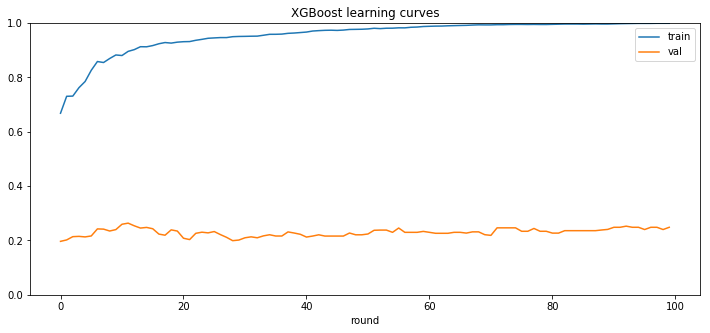

In [6]:
evals_result = clf.evals_result()
#train_errors = evals_result['validation_0']['logloss']
#validation_errors = evals_result['validation_1']['logloss']
train_errors = evals_result['validation_0']['aucpr']
validation_errors = evals_result['validation_1']['aucpr']
df = pd.DataFrame([train_errors, validation_errors]).T
df.columns = ['train', 'val']
df.index.name = 'round'
df.plot(title='XGBoost learning curves', ylim=(0.0,1.0), figsize=(12,5))

In [ ]:
print(ratio)

In [7]:
#xgb.XGBClassifier?
#xgb.cv?
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

params_fixed = {
#    'objective': 'binary:logistic',
#    'silent': True,
#    'max_depth': 2,
#    'n_estimators': 150, # Got 5 after turning grid search for neg_mean_absolute_error,using 10 for a little bit of margin...
    'scale_pos_weight': ratio,
    'learning_rate': .005,
    'eval_metric': 'aucpr', #'logloss',
#    'subsample': 0.2,
#    'colsample_bytree': 0.8,
}

params_dist_grid = {
    'n_estimators': [10, 20, 30, 40, 50, 100, 500, 1500],
#   'subsample': [0, .2, .4, .6, .8, 1],
#   'colsample_bytree': [0, .2, .4, .6, .8, 1],
#    'gamma': [0, .2, .4, .6, .8, 1],
#    'min_child_weight': [.1, 1, 2, 5, 10]
#    'scale_pos_weight':[2.5, 3, 3.5, 4]
}
model_grid = GridSearchCV(
    estimator = xgb.XGBClassifier(**params_fixed, random_state=seed),
    param_grid = params_dist_grid,
    cv = cv,
    scoring = 'neg_log_loss', # 'neg_log_loss', # ('neg_log_loss'), #, 'roc_auc'),
    iid = True,                # This is the default. Not 100% this is correct?
    refit = 'neg_log_loss' # 'neg_log_loss' # 'neg_log_loss'     # True
)

In [8]:
# This could run a while, be careful of running it for fun ;-)
model_grid.fit(X_train, y_train, 
               eval_set = [(X_train, y_train), (X_val, y_val)],
               verbose=10,
               early_stopping_rounds=40)

[0]	validation_0-aucpr:0.670448	validation_1-aucpr:0.153819
Multiple eval metrics have been passed: 'validation_1-aucpr' will be used for early stopping.

Will train until validation_1-aucpr hasn't improved in 40 rounds.
[9]	validation_0-aucpr:0.74794	validation_1-aucpr:0.178414
[0]	validation_0-aucpr:0.678246	validation_1-aucpr:0.142405
Multiple eval metrics have been passed: 'validation_1-aucpr' will be used for early stopping.

Will train until validation_1-aucpr hasn't improved in 40 rounds.
[9]	validation_0-aucpr:0.678246	validation_1-aucpr:0.142405
[0]	validation_0-aucpr:0.692506	validation_1-aucpr:0.172458
Multiple eval metrics have been passed: 'validation_1-aucpr' will be used for early stopping.

Will train until validation_1-aucpr hasn't improved in 40 rounds.
[9]	validation_0-aucpr:0.744515	validation_1-aucpr:0.176325
[0]	validation_0-aucpr:0.660538	validation_1-aucpr:0.163943
Multiple eval metrics have been passed: 'validation_1-aucpr' will be used for early stopping.

Wil

[0]	validation_0-aucpr:0.675277	validation_1-aucpr:0.163943
Multiple eval metrics have been passed: 'validation_1-aucpr' will be used for early stopping.

Will train until validation_1-aucpr hasn't improved in 40 rounds.
[10]	validation_0-aucpr:0.739315	validation_1-aucpr:0.180654
[20]	validation_0-aucpr:0.742678	validation_1-aucpr:0.170544
[29]	validation_0-aucpr:0.74882	validation_1-aucpr:0.178268
[0]	validation_0-aucpr:0.676236	validation_1-aucpr:0.152363
Multiple eval metrics have been passed: 'validation_1-aucpr' will be used for early stopping.

Will train until validation_1-aucpr hasn't improved in 40 rounds.
[10]	validation_0-aucpr:0.735358	validation_1-aucpr:0.152363
[20]	validation_0-aucpr:0.733688	validation_1-aucpr:0.152363
[29]	validation_0-aucpr:0.740998	validation_1-aucpr:0.152363
[0]	validation_0-aucpr:0.499314	validation_1-aucpr:0.167859
Multiple eval metrics have been passed: 'validation_1-aucpr' will be used for early stopping.

Will train until validation_1-aucpr ha

Stopping. Best iteration:
[0]	validation_0-aucpr:0.692506	validation_1-aucpr:0.172458

[0]	validation_0-aucpr:0.660538	validation_1-aucpr:0.163943
Multiple eval metrics have been passed: 'validation_1-aucpr' will be used for early stopping.

Will train until validation_1-aucpr hasn't improved in 40 rounds.
[10]	validation_0-aucpr:0.689385	validation_1-aucpr:0.185544
[20]	validation_0-aucpr:0.685947	validation_1-aucpr:0.213662
[30]	validation_0-aucpr:0.689837	validation_1-aucpr:0.213662
[40]	validation_0-aucpr:0.689837	validation_1-aucpr:0.213662
Stopping. Best iteration:
[0]	validation_0-aucpr:0.660538	validation_1-aucpr:0.163943

[0]	validation_0-aucpr:0.66272	validation_1-aucpr:0.143848
Multiple eval metrics have been passed: 'validation_1-aucpr' will be used for early stopping.

Will train until validation_1-aucpr hasn't improved in 40 rounds.
[10]	validation_0-aucpr:0.653168	validation_1-aucpr:0.143848
[20]	validation_0-aucpr:0.653168	validation_1-aucpr:0.143848
[30]	validation_0-a

[0]	validation_0-aucpr:0.499314	validation_1-aucpr:0.167859
Multiple eval metrics have been passed: 'validation_1-aucpr' will be used for early stopping.

Will train until validation_1-aucpr hasn't improved in 40 rounds.
[10]	validation_0-aucpr:0.67415	validation_1-aucpr:0.146846
[20]	validation_0-aucpr:0.690512	validation_1-aucpr:0.146846
[30]	validation_0-aucpr:0.689597	validation_1-aucpr:0.146846
[40]	validation_0-aucpr:0.709439	validation_1-aucpr:0.188724
Stopping. Best iteration:
[2]	validation_0-aucpr:0.640055	validation_1-aucpr:0.146846

[0]	validation_0-aucpr:0.647968	validation_1-aucpr:0.187599
Multiple eval metrics have been passed: 'validation_1-aucpr' will be used for early stopping.

Will train until validation_1-aucpr hasn't improved in 40 rounds.
[10]	validation_0-aucpr:0.647968	validation_1-aucpr:0.187599
[20]	validation_0-aucpr:0.65689	validation_1-aucpr:0.187599
[30]	validation_0-aucpr:0.65689	validation_1-aucpr:0.187599
[40]	validation_0-aucpr:0.719072	validation_1-a

[40]	validation_0-aucpr:0.815504	validation_1-aucpr:0.182355
Stopping. Best iteration:
[0]	validation_0-aucpr:0.670448	validation_1-aucpr:0.153819

[0]	validation_0-aucpr:0.678246	validation_1-aucpr:0.142405
Multiple eval metrics have been passed: 'validation_1-aucpr' will be used for early stopping.

Will train until validation_1-aucpr hasn't improved in 40 rounds.
[10]	validation_0-aucpr:0.678246	validation_1-aucpr:0.142405
[20]	validation_0-aucpr:0.678246	validation_1-aucpr:0.142405
[30]	validation_0-aucpr:0.678246	validation_1-aucpr:0.142405
[40]	validation_0-aucpr:0.678246	validation_1-aucpr:0.142405
Stopping. Best iteration:
[0]	validation_0-aucpr:0.678246	validation_1-aucpr:0.142405

[0]	validation_0-aucpr:0.692506	validation_1-aucpr:0.172458
Multiple eval metrics have been passed: 'validation_1-aucpr' will be used for early stopping.

Will train until validation_1-aucpr hasn't improved in 40 rounds.
[10]	validation_0-aucpr:0.744929	validation_1-aucpr:0.176325
[20]	validation_0-

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=43, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='aucpr', gamma=0,
       learning_rate=0.005, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=43,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=2.519230769230769,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=None,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 100, 500, 1500]},
       pre_dispatch='2*n_jobs', refit='neg_log_loss',
       return_train_score='warn', scoring='neg_log_loss', verbose=0)

In [9]:
for key, value in model_grid.best_params_.items():
    print("\t{}: {}".format(key, value))

	n_estimators: 100


In [10]:
clf = model_grid.best_estimator_

In [11]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)
predROC = clf.predict_proba(X_test)[:,1]

accuracy = accuracy_score(y_test, y_pred)
precision=precision_score(y_test, y_pred)
recall=recall_score(y_test, y_pred)
roc=roc_auc_score(y_test,predROC)

print('  Accuracy:  {:.3f}'.format(accuracy))
print('     Error:  {:.3f}'.format(1 - accuracy))
print(' Precision:  {:.3f}'.format(precision))
print('       AUC:  {:.3f}'.format(roc))
print('')
print('    Recall:  {:.3f}'.format(recall))
correct = 0
for i in range(len(y_test)):
    if (list(y_pred)[i] == list(y_test)[i]):
        correct = correct + 1
print(" % Correct: {:.3f}".format(correct/len(y_test)*100))
pd.crosstab(
    pd.Series(y_test.values, name='Actual'),
    pd.Series(y_pred, name='Predicted'),
    margins=True
)

  Accuracy:  0.800
     Error:  0.200
 Precision:  0.500
       AUC:  0.660

    Recall:  0.625
 % Correct: 80.000


Predicted,0.0,1.0,All
Actual,,,
0.0,27,5,32
1.0,3,5,8
All,30,10,40


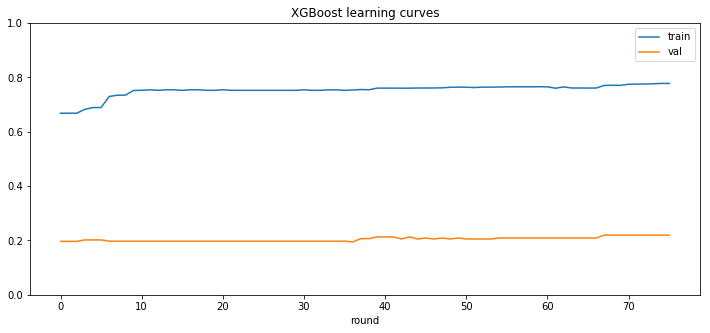

In [12]:
evals_result = clf.evals_result()
#train_errors = evals_result['validation_0']['logloss']
#validation_errors = evals_result['validation_1']['logloss']
train_errors = evals_result['validation_0']['aucpr']
validation_errors = evals_result['validation_1']['aucpr']
df = pd.DataFrame([train_errors, validation_errors]).T
df.columns = ['train', 'val']
df.index.name = 'round'
df.plot(title='XGBoost learning curves', ylim=(0.0,1.0), figsize=(12,5))

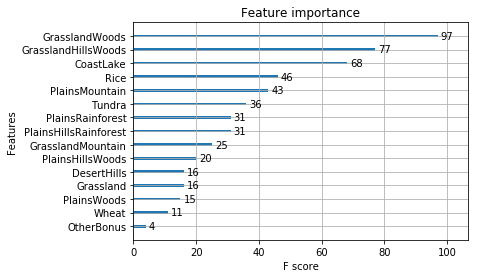

In [13]:
plot_importance(clf)
plt.rcParams['figure.figsize'] = [12, 8]
plt.show()

In [29]:
xgb.cv?

In [15]:
explainer.expected_value

-0.004751521

In [14]:
# Explain model's predictions using SHAP values
# same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(allX)# (X_test)

In [ ]:
# visualise the first prediction's explanation - the index here is the "number" of the output class!
#shap.force_plot(explainer.expected_value, shap_values, allX)

In [ ]:
idx1 = allX.columns.get_loc('Grassland')
idx2 = allX.columns.get_loc('Grassland')
shap.dependence_plot(idx1, shap_values, allX, None, None, idx2)

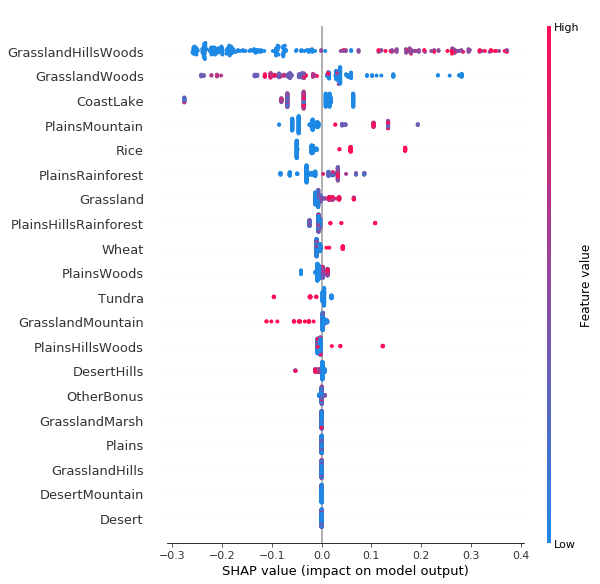

In [16]:
#shap.summary_plot(shap_values, X_test, class_names=['poor', 'good'])
shap.summary_plot(shap_values, allX)

In [ ]:
featuresOfInterest = ['Grassland', 'Plains', 'PlainsMountain', 'Stone', 'GrasslandHillsWoods',
                      'PlainsRainforest', 'Bananas', 'PlainsWoods', 'PlainsHillsRainforest',
                      'Rice', 'GrasslandHills', 'CoastLake', 'GrasslandWoods', 'Wheat',
                      'PlainsHillsWoods', 'Spices', 'Sheep', 'Horses', 'Mercury', 'CoastLakeReef']
for f in featuresOfInterest:
    print("{:>22} :- Min: {:>2}  Max: {:>2}  Mean: {:.2f}".format(f,
        allX[f].min().astype('int'),
        allX[f].max().astype('int'),
        allX[f].mean()))
    
# Misleading information as the data is highly skewed towards 0! (And I think shapley values are per city, not per feature?)

In [ ]:
display(xgb.to_graphviz(clf, num_trees=0))
display(xgb.to_graphviz(clf, num_trees=1))
display(xgb.to_graphviz(clf, num_trees=2))
display(xgb.to_graphviz(clf, num_trees=3))
display(xgb.to_graphviz(clf, num_trees=4))
display(xgb.to_graphviz(clf, num_trees=5))
display(xgb.to_graphviz(clf, num_trees=6))
display(xgb.to_graphviz(clf, num_trees=7))
display(xgb.to_graphviz(clf, num_trees=8))
display(xgb.to_graphviz(clf, num_trees=9))

In [ ]:
df = pd.DataFrame(shap_values, columns=allX.columns.values)
print(df.shape)
print(df.head)

In [ ]:
clf.get_booster().dump_model('test-model-output.json', with_stats=True, dump_format='json')